### 可视化 View Attention
1. 获取 attention scores，要利用前向传播
2. 用什么方式呈现？
    1. heatmap
    2. colored line

In [12]:
import sys
BASE_DIR = '/mnt/sdb/public/data/jerry/iGitRepo/viewformer'
sys.path.append(BASE_DIR)

import torch
from torch.utils.data import DataLoader

from models.naive import BaseImageClassifier, MultiViewTransformer
from datasets.data import ModelNet_MultiView

### 生成 attention scores

In [13]:
# define model
model_name = 'alexnet'
rank = 1
sv_classifier = BaseImageClassifier(
    model_name=model_name, base_feature_dim=512,  
    num_channels=512, num_classes=40).to(rank)

num_layers = 4
num_views = 8
clshead_layers = 1
model = MultiViewTransformer(
    sv_classifier.feature_extractor, base_feature_dim=512, 
    num_layers=num_layers, num_heads=8,
    num_channels=512, widening_factor=2, 
    max_dpr=.0, atten_drop=0.1, mlp_drop=0.5, 
    num_views=num_views, clshead_layers=clshead_layers,
    num_classes=40, vis_flag=True,
).to(rank)

In [14]:
# load well-trained weights
# model_weights = '../runs/CLS/viewformer_naive/MN40-V20-L4H8D512-MR2-Alex-1/weights/mv_model_best.pth'
model_weights = '../runs/CLS/vf_naive_num_views/MN40-V8-L4H8D512-MR2-Alex-2/weights/mv_model_best.pth'
map_location = torch.device('cuda:%d' % rank)
state_dict = torch.load(model_weights, map_location=map_location)

model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [15]:
# define multi-view image dataset
num_obj_classes = 40

# train_path = 'data/modelnet40v2png_ori4'
# mv_train_set = ModelNet_MultiView(train_path, num_classes=num_obj_classes)
# num_train_objects = len(mv_train_set)
# print('MN40 num_train_objects:', num_train_objects)

test_path = '../data/modelnet40v2png_ori4'
mv_test_set = ModelNet_MultiView(test_path, test_mode=True, num_views=num_views, num_classes=num_obj_classes)
num_test_objects = len(mv_test_set)
print('MN40 num_test_objects:', num_test_objects)

# load multi-view image dataset
mv_samples_per_gpu = 75
num_workers = 1
# mv_train_loader = DataLoader(mv_train_set, batch_size=mv_samples_per_gpu, 
                            # shuffle=False, num_workers=num_workers, pin_memory=True,)
mv_test_loader = DataLoader(mv_test_set, batch_size=mv_samples_per_gpu, 
                            shuffle=False, num_workers=num_workers, pin_memory=True,)

MN40 num_test_objects: 2468


In [16]:
print('len(mv_test_set.filepaths):', len(mv_test_set.filepaths))
print(mv_test_set.filepaths[0])
print(mv_test_set.filepaths[1])

len(mv_test_set.filepaths): 19744
../data/modelnet40v2png_ori4/airplane/test/airplane_0627_003.png
../data/modelnet40v2png_ori4/airplane/test/airplane_0627_006.png


In [17]:
print('len(mv_test_loader):', len(mv_test_loader))

len(mv_test_loader): 33


In [18]:
count = 0
stop = 25

# forward pass to get `atten_scores_list` 
with torch.no_grad():
    for data in mv_test_loader:
        B, V, C, H, W = data[1].size()
        in_data = data[1].view(-1, C, H, W).to(rank)
        # print('--- in_data.device:', in_data.device)
        
        # logits: [batch, num_obj_classes]
        # atten_scores_list: [num_layers, batch_size*num_heads, num_views, num_views)]
        logits, atten_scores_list = model(in_data)

        count += 1
        if count == stop:
            break

In [19]:
print('logits.shape', logits.shape)
print('len(atten_scores_list):', len(atten_scores_list))
# atten_scores_list[0].shape:[600, num_views, num_views]
#   这个600是哪来的，没想明白，600 = 75*8
print('atten_scores_list[0].shape:', atten_scores_list[0].shape)

logits.shape torch.Size([75, 40])
len(atten_scores_list): 4
atten_scores_list[0].shape: torch.Size([600, 8, 8])


In [20]:
print('atten_scores_list[1].shape:', atten_scores_list[1].shape)

atten_scores_list[1].shape: torch.Size([600, 8, 8])


In [21]:
from einops import rearrange

atten_scores = atten_scores_list[num_layers-1]  # attention scores in final layer
atten_scores = rearrange(atten_scores, '(b h) v1 v2 -> b h v1 v2', b=mv_samples_per_gpu)

# average over all heads
atten_scores = torch.mean(atten_scores, dim=1)
print('atten_scores.shape:', atten_scores.shape)

in_data = rearrange(in_data, '(b v) c h w -> b v c h w', b=mv_samples_per_gpu)
print('in_data.shape:', in_data.shape)

atten_scores.shape: torch.Size([75, 8, 8])
in_data.shape: torch.Size([75, 8, 3, 224, 224])


In [22]:
first_batch_atten_scores = atten_scores[0]
print('first_batch_atten_scores.shape:', first_batch_atten_scores.shape)

first_batch_images = in_data[0]
print('first_batch_images.shape:', first_batch_images.shape)

first_batch_atten_scores.shape: torch.Size([8, 8])
first_batch_images.shape: torch.Size([8, 3, 224, 224])


In [23]:
first_batch_atten_scores.cpu().numpy()

array([[0.11131753, 0.0613708 , 0.06160036, 0.06656249, 0.23270576,
        0.10446341, 0.20489475, 0.15708488],
       [0.16307043, 0.0382603 , 0.04552017, 0.05172227, 0.24941966,
        0.03925051, 0.2804758 , 0.13228086],
       [0.11545151, 0.03140289, 0.04846797, 0.089151  , 0.23446456,
        0.09615366, 0.20091607, 0.18399234],
       [0.13522705, 0.04662966, 0.05324885, 0.0661804 , 0.28478074,
        0.03520616, 0.24682559, 0.13190153],
       [0.08891174, 0.03374038, 0.05118284, 0.05912194, 0.3003733 ,
        0.05414844, 0.26233816, 0.15018323],
       [0.14525065, 0.03271305, 0.11743383, 0.07531937, 0.22745876,
        0.04766309, 0.22155221, 0.13260905],
       [0.1460079 , 0.0388358 , 0.03851502, 0.10646994, 0.22802368,
        0.03701444, 0.17114042, 0.23399282],
       [0.12340596, 0.03634678, 0.10093841, 0.04719039, 0.23406634,
        0.03742334, 0.27718395, 0.1434448 ]], dtype=float32)

In [24]:
scores = first_batch_atten_scores.cpu().numpy()
# images = first_batch_images.cpu().transpose(1,3).transpose(1,2).numpy()
images = first_batch_images.permute(0, 2, 3, 1).cpu().numpy()
print('images.shape:', images.shape)
# print('image[0]:', images[0].astype('uint8'))

images.shape: (8, 224, 224, 3)


### 绘制 attention heatmap

In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [26]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

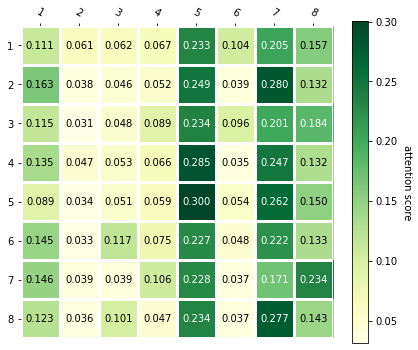

In [27]:
# --- option 1. attention scores with residual 
#   add residual to each view
# attentions = scores + np.eye(len(scores))
# # compute sum of all columns for each row
# attn_col_sum = attentions.sum(axis=-1)
# # normalize `attentions` per row
# attentions = attentions / attn_col_sum[None, :]

# --- option 2. attention scores without residual 
attentions = scores

view_ids = list(range(1,num_views+1))

fig, ax = plt.subplots(figsize=(6,5))

# 好像是网络没训练的原因，看不出来有什么规律，另外还得可视化一下 20 views
im, cbar = heatmap(attentions, view_ids, view_ids, ax=ax,
                   cmap="YlGn", cbarlabel="attention score")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()
fig.savefig('images/8views_attn_map.pdf', dpi=400.0, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


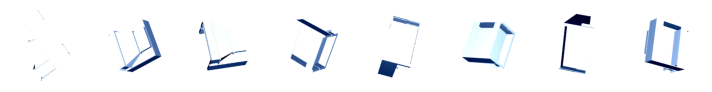

In [28]:
# show 20 views in one figure
# NOTE 这图看起来不太正常，要找原因让它显示正常

nrows, ncols = 1, num_views
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 2))

for row in range(nrows):
    for col in range(ncols):
        # bgr color channel
        image = images[row*ncols + col]
        # bgr -> rgb 
        # image = image[...,::-1].copy()
        # axes[row, col].imshow(image)
        # axes[row, col].set_axis_off()

        axes[col].imshow(image)
        axes[col].set_axis_off()

# fig.subplots_adjust(wspace=0.05, hspace=0.001)
fig.tight_layout()

In [29]:
# from torchvision.utils import make_grid
# import imageio

# with torch.no_grad():
#     im = make_grid(first_batch_images, nrow=num_views).cpu().transpose(0, 2).transpose(0, 1).numpy()
#     imageio.imsave(f'images/{num_views}views_nightstand.png', (255*im).astype(np.uint8))

In [30]:
selected_image_files = mv_test_set.filepaths[14440:14448]   # 范围选到什么属于 night_stand
selected_image_files

['../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_004.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_012.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_003.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_011.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_018.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_015.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_009.png',
 '../data/modelnet40v2png_ori4/range_hood/test/range_hood_0173_010.png']

### 绘制 attention colored line

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.colors as mcolors

def load_images(pathes):
    images = []
    for path in pathes:
        images.append(plt.imread(path))
    return images

# Load the RGB images
image_files = selected_image_files
# image_files=[f.split('/')[-1] for f in pathes if f.endswith('.png')] 
images = load_images(image_files)

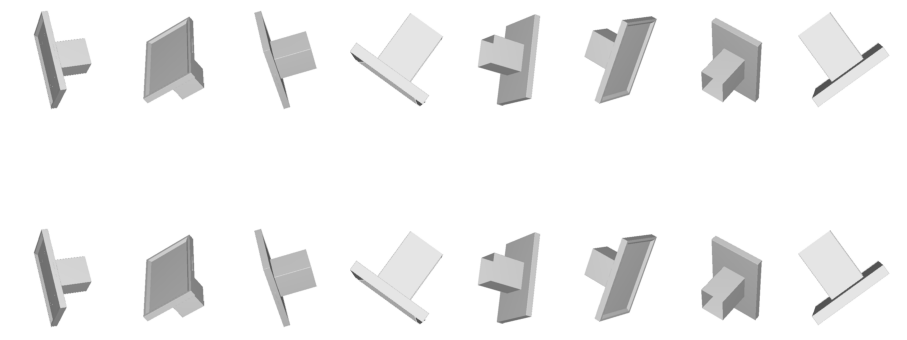

In [32]:
# Set up the figure and subplots
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(3, 8, figure=fig, wspace=0.0, hspace=0.0)
ax = []
for i in range(24):
    ax.append(fig.add_subplot(gs[i]))

# Remove borders and ticks from all subplots
for a in ax:
    a.axis('off')
    a.tick_params(axis='both', which='both', length=0)

# Plot the images in the first and third rows
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[16+i].imshow(images[i])

In [33]:
type(ax[0].get_position().get_points()) # [[left bottom], [right top]]
len(ax)

24

In [34]:
def get_endpoints(ax):
    top_points = []
    bottom_points = []
    print(len(ax))
    for i in range(len(ax)//3):
        top_points.append(ax[i].get_position().get_points()[0])
        bottom_points.append(ax[i+16].get_position().get_points()[1])
    
    top_endpoints = []
    bottom_endpoints = []

    for i in range(len(top_points)-1):
        left = top_points[i]
        right = top_points[i+1]
        mid = (left+right)/2
        top_endpoints.append(mid)
    right_end = (top_points[-1] + np.array([bottom_points[-1][0], top_points[-1][1]]))/2
    top_endpoints.append(right_end)


    left_end = (np.array([top_points[0][0], bottom_points[0][1]]) +bottom_points[0]) /2
    bottom_endpoints.append(left_end)
    for i in range(len(bottom_points)-1):
        left = bottom_points[i]
        right = bottom_points[i+1]
        mid = (left+right)/2
        bottom_endpoints.append(mid)
    return top_endpoints, bottom_endpoints        

In [35]:
top_endpoints, bottom_endpoints = get_endpoints(ax)
top_endpoints
bottom_endpoints

24


[array([0.1734375 , 0.37666667]),
 array([0.2690625 , 0.37666667]),
 array([0.3659375 , 0.37666667]),
 array([0.4628125 , 0.37666667]),
 array([0.5596875 , 0.37666667]),
 array([0.6565625 , 0.37666667]),
 array([0.7534375 , 0.37666667]),
 array([0.8503125 , 0.37666667])]

In [36]:
attn_score = first_batch_atten_scores.cpu().numpy()
print('--- attn_score\n', attn_score)
normalized_score = attn_score / attn_score.max(axis=1, keepdims=True)
print('--- normalized_score\n', normalized_score)

--- attn_score
 [[0.11131753 0.0613708  0.06160036 0.06656249 0.23270576 0.10446341
  0.20489475 0.15708488]
 [0.16307043 0.0382603  0.04552017 0.05172227 0.24941966 0.03925051
  0.2804758  0.13228086]
 [0.11545151 0.03140289 0.04846797 0.089151   0.23446456 0.09615366
  0.20091607 0.18399234]
 [0.13522705 0.04662966 0.05324885 0.0661804  0.28478074 0.03520616
  0.24682559 0.13190153]
 [0.08891174 0.03374038 0.05118284 0.05912194 0.3003733  0.05414844
  0.26233816 0.15018323]
 [0.14525065 0.03271305 0.11743383 0.07531937 0.22745876 0.04766309
  0.22155221 0.13260905]
 [0.1460079  0.0388358  0.03851502 0.10646994 0.22802368 0.03701444
  0.17114042 0.23399282]
 [0.12340596 0.03634678 0.10093841 0.04719039 0.23406634 0.03742334
  0.27718395 0.1434448 ]]
--- normalized_score
 [[0.47836173 0.26372704 0.2647135  0.28603715 1.         0.44890773
  0.8804885  0.6750365 ]
 [0.5814064  0.13641213 0.16229625 0.18440904 0.8892734  0.1399426
  1.         0.47163022]
 [0.49240497 0.13393448 0.206717

24


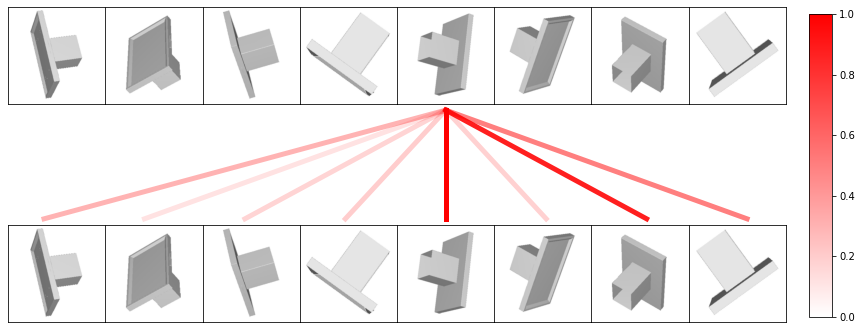

In [37]:
# Set up the figure and subplots
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(3, 8, figure=fig, wspace=0.0, hspace=0.0)
ax = []
for i in range(24):
    ax.append(fig.add_subplot(gs[i]))

# Remove borders and ticks from all subplots
for a in ax:
    # a.axis('off')
    # a.tick_params(axis='both', which='both', length=0)
    a.tick_params(axis='both', which='both', length=1)

    a.set_xticks([])
    a.set_yticks([])
    # a.set_frame_on(False)

for a in ax[8:16]:
    a.axis('off')
    # a.tick_params(axis='both', which='both', length=0)

top_endpoints, bottom_endpoints = get_endpoints(ax)
top_endpoints = np.array(top_endpoints).T
bottom_endpoints = np.array(bottom_endpoints).T
# Plot the images in the first and third rows
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[16+i].imshow(images[i])
# Connect the images with lines

# anchor 
anchor_idx = 4
alpha = normalized_score[anchor_idx]

anchor_point = top_endpoints[:, anchor_idx]
anchor_point[0] *= 0.9
bottom_endpoints[0, :] *= 0.9

"""
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 
'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 
'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 
'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 
'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 
'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 
'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 
'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 
'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 
'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
'viridis', 'viridis_r', 'winter', 'winter_r'
"""

for i in range(8):
    top_x = top_endpoints[0, i]
    top_y = top_endpoints[1, i]
    bottom_x = bottom_endpoints[0, i]
    bottom_y = bottom_endpoints[1, i]
    fig.add_artist(plt.Line2D([anchor_point[0], bottom_x],
     [anchor_point[1], bottom_y], color='red', alpha=alpha[i], linewidth=5))
    
fig.subplots_adjust(right=0.8)

red_cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "red"])
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=red_cmap, norm=norm)

cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# plt.colorbar(cax=cax)
fig.colorbar(sm, cax=cbar_ax, orientation='vertical')

# Show the plot
plt.show()
fig.savefig('images/8rangehoods_attn_lines.pdf', dpi=400, bbox_inches='tight')

24


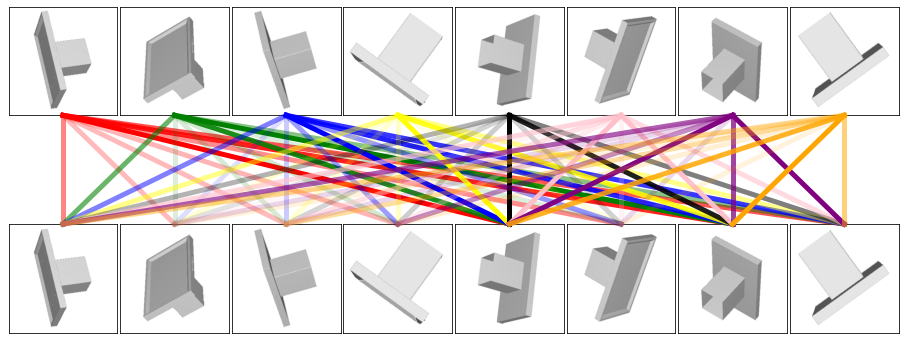

In [38]:
# Set up the figure and subplots
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(3, 8, figure=fig, wspace=0.0, hspace=0.0)
ax = []
for i in range(24):
    ax.append(fig.add_subplot(gs[i]))

# Remove borders and ticks from all subplots
for a in ax:
    # a.axis('off')
    # a.tick_params(axis='both', which='both', length=0)
    a.tick_params(axis='both', which='both', length=1)

    a.set_xticks([])
    a.set_yticks([])
    # a.set_frame_on(False)

for a in ax[8:16]:
    a.axis('off')
    # a.tick_params(axis='both', which='both', length=0)

top_endpoints, bottom_endpoints = get_endpoints(ax)
top_endpoints = np.array(top_endpoints).T
bottom_endpoints = np.array(bottom_endpoints).T
# Plot the images in the first and third rows
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[16+i].imshow(images[i])
# Connect the images with lines

# anchor 
color = ['red', 'green', 'blue', 'yellow', 'black', 'pink', 'purple', 'orange']

# for i in range(8):
#     top_x = top_endpoints[0, i]
#     top_y = top_endpoints[1, i]
#     bottom_x = bottom_endpoints[0, i]
#     bottom_y = bottom_endpoints[1, i]
#     fig.add_artist(plt.Line2D([anchor_point[0], bottom_x], [anchor_point[1], bottom_y], color='blue', alpha=alpha[i]))
    
for i in range(8):
    for j in range(8):
        top_x = top_endpoints[0, i]
        top_y = top_endpoints[1, i]
        bottom_x = bottom_endpoints[0, j]
        bottom_y = bottom_endpoints[1, j]
        fig.add_artist(plt.Line2D([top_x, bottom_x], [top_y, bottom_y], color=color[i], alpha=normalized_score[i, j], linewidth=5))

# Show the plot
plt.show()
fig.savefig('images/8rangehoods_attn_all_lines.pdf', dpi=400, bbox_inches='tight')

### 检索结果可视化

In [39]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def img_reshape(img):
    img = Image.open(img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img

In [40]:
retrieved_images_dir = '../retrieval/retrieval_examples'

img_arr = []
id2image = {}

for cls in os.listdir(retrieved_images_dir):

    images = glob.glob(f'{retrieved_images_dir}/{cls}/*.png')

    for image in images:
        if '_query.png' in image:
            id2image[0] = image
        elif '_query.png' not in image:
            # search in reversed direction since `retrieval_examples` also contains `_`
            start = image.rfind('_') + 1
            end = image.find('.png')
            # image id corresponds to its order in `img_arr`
            id = int(image[start:end])
            id2image[id] = image

    print(f'--- {cls}')
    for id in range(11):
        img_arr.append(img_reshape(id2image[id]))
        # print(f'------ {id2image[id]}')

--- desk
--- keyboard
--- cup
--- skateboard
--- pistol
--- airplane
--- chair
--- ship
--- knife
--- motorcycle


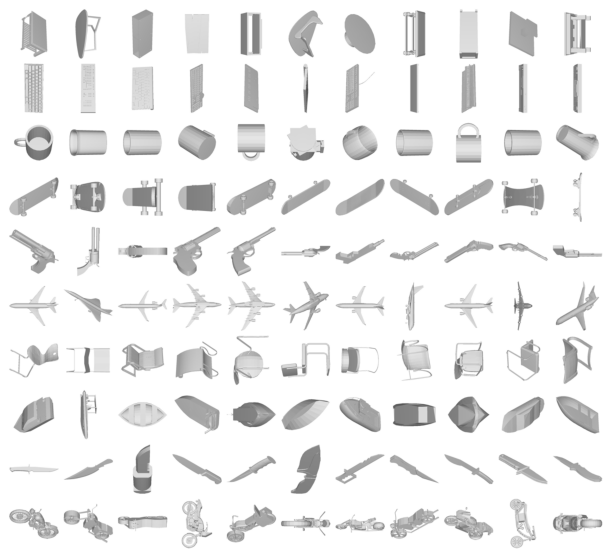

In [41]:
def image_grid(array, ncols=10):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, channels))
    
    return img_grid

result = image_grid(np.array(img_arr), ncols=11)
fig = plt.figure(figsize=(11., 10.))    # width, height

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(result)

In [42]:
img_name = 'images/retrieved_top10.pdf'
fig.savefig(img_name, dpi=400., pad_inches=.0)

### 分类特征分布可视化

In [43]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

import torch

1. ModelNet10

In [44]:
state_dict = torch.load('MN10_test_feats_labels.pth', map_location=torch.device('cpu'))
state_dict.keys()

print(state_dict['feats_test'].shape)
print(state_dict['feats_test'][0].shape)
print(state_dict['labels_test'].shape)
print(state_dict['labels_test'][0].shape)

# 生成t-SNE嵌入特征，feats_test_embedded.shape: (1024, 2)，第一维代表样本数，第二位代表tsne嵌入空间维度
feats_test_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(state_dict['feats_test'])

df = pd.DataFrame()
# y是样本类别，每个样本都有个类别，所以维度是1024
df["label"] = state_dict['labels_test']
df["axis-0"] = feats_test_embedded[:,0]
df["axis-1"] = feats_test_embedded[:,1]

(908, 10)
(10,)
(908,)
()


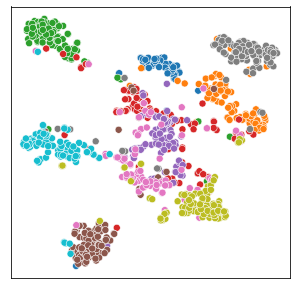

In [45]:
# 控制图片大小
figsize = (5, 5)
fig, ax = plt.subplots(figsize=figsize)
mn_ax = sns.scatterplot(ax=ax, x="axis-0", y="axis-1", hue=df.label.tolist(),
                palette=sns.color_palette(palette=None, n_colors=10), s=50,
                data=df, legend=False)#.set(title="CrossFormer Pretrained Features on ScanObjectNN")
mn_ax.set(xlabel=None)
mn_ax.set(ylabel=None)
plt.xticks([])
plt.yticks([])
plt.show()

mn_fig = mn_ax.get_figure()
mn_fig.savefig('mn10_feats.pdf', dpi=400.0, bbox_inches='tight')

# NOTE 下面这个图片感觉类别划分的不是特别清楚，和100%的分类准确性不太符合
#   1. 有种可能性是 t-SNE 工作的不好，而不是我数据的问题，当然先要检查数据

2. ModelNet40

In [46]:
state_dict = torch.load('MN40_test_feats_labels.pth', map_location=torch.device('cpu'))
state_dict.keys()

print(state_dict['feats_test'].shape)
print(state_dict['feats_test'][0].shape)
print(state_dict['labels_test'].shape)
print(state_dict['labels_test'][0].shape)

# 生成t-SNE嵌入特征，feats_test_embedded.shape: (1024, 2)，第一维代表样本数，第二位代表tsne嵌入空间维度
feats_test_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(state_dict['feats_test'])

df = pd.DataFrame()
# y是样本类别，每个样本都有个类别，所以维度是1024
df["label"] = state_dict['labels_test']
df["axis-0"] = feats_test_embedded[:,0]
df["axis-1"] = feats_test_embedded[:,1]

(2468, 40)
(40,)
(2468,)
()


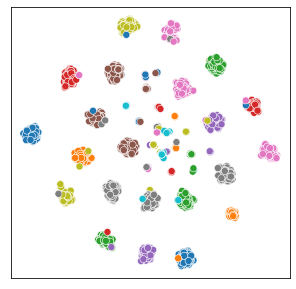

In [47]:
# 控制图片大小
figsize = (5, 5)
fig, ax = plt.subplots(figsize=figsize)
mn_ax = sns.scatterplot(ax=ax, x="axis-0", y="axis-1", hue=df.label.tolist(),
                palette=sns.color_palette(palette=None, n_colors=40), s=50,
                data=df, legend=False)#.set(title="CrossFormer Pretrained Features on ScanObjectNN")
mn_ax.set(xlabel=None)
mn_ax.set(ylabel=None)
plt.xticks([])
plt.yticks([])
plt.show()

mn_fig = mn_ax.get_figure()
mn_fig.savefig('mn40_feats.pdf', dpi=400.0, bbox_inches='tight')

3. RGBD

In [48]:
state_dict = torch.load('RGBD_test_feats_labels.pth', map_location=torch.device('cpu'))
state_dict.keys()

print(state_dict['feats_test'].shape)
print(state_dict['feats_test'][0].shape)
print(state_dict['labels_test'].shape)
print(state_dict['labels_test'][0].shape)

# 生成t-SNE嵌入特征，feats_test_embedded.shape: (1024, 2)，第一维代表样本数，第二位代表tsne嵌入空间维度
feats_test_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(state_dict['feats_test'])

df = pd.DataFrame()
# y是样本类别，每个样本都有个类别，所以维度是1024
df["label"] = state_dict['labels_test']
df["axis-0"] = feats_test_embedded[:,0]
df["axis-1"] = feats_test_embedded[:,1]

(337, 51)
(51,)
(337,)
()


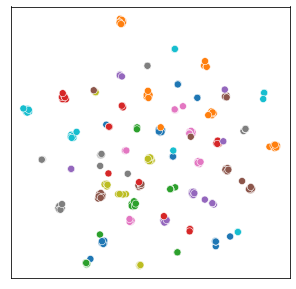

In [49]:
# 控制图片大小
figsize = (5, 5)
fig, ax = plt.subplots(figsize=figsize)
mn_ax = sns.scatterplot(ax=ax, x="axis-0", y="axis-1", hue=df.label.tolist(),
                palette=sns.color_palette(palette=None, n_colors=51), s=50,
                data=df, legend=False)#.set(title="CrossFormer Pretrained Features on ScanObjectNN")
mn_ax.set(xlabel=None)
mn_ax.set(ylabel=None)
plt.xticks([])
plt.yticks([])
plt.show()

mn_fig = mn_ax.get_figure()
mn_fig.savefig('rgbd_feats.pdf', dpi=400.0, bbox_inches='tight')

4. SONN

In [50]:
state_dict = torch.load('SONN_test_feats_labels.pth', map_location=torch.device('cpu'))
state_dict.keys()

print(state_dict['feats_test'].shape)
print(state_dict['feats_test'][0].shape)
print(state_dict['labels_test'].shape)
print(state_dict['labels_test'][0].shape)

# 生成t-SNE嵌入特征，feats_test_embedded.shape: (1024, 2)，第一维代表样本数，第二位代表tsne嵌入空间维度
feats_test_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(state_dict['feats_test'])

df = pd.DataFrame()
# y是样本类别，每个样本都有个类别，所以维度是1024
df["label"] = state_dict['labels_test']
df["axis-0"] = feats_test_embedded[:,0]
df["axis-1"] = feats_test_embedded[:,1]

(583, 15)
(15,)
(583,)
()


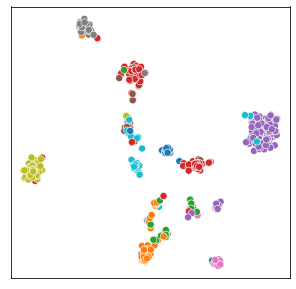

In [51]:
# 控制图片大小
figsize = (5, 5)
fig, ax = plt.subplots(figsize=figsize)
mn_ax = sns.scatterplot(ax=ax, x="axis-0", y="axis-1", hue=df.label.tolist(),
                palette=sns.color_palette(palette=None, n_colors=15), s=50,
                data=df, legend=False)#.set(title="CrossFormer Pretrained Features on ScanObjectNN")
mn_ax.set(xlabel=None)
mn_ax.set(ylabel=None)
plt.xticks([])
plt.yticks([])
plt.show()

mn_fig = mn_ax.get_figure()
mn_fig.savefig('sonn_feats.pdf', dpi=400.0, bbox_inches='tight')

### 论文正文 Figure 3，保存为PDF

In [52]:
scores = [
    [.119, .134, .088, .100, .105, .219, .138, .097],
    [.118, .128, .109, .084, .093, .208, .161, .099],
    [.109, .143, .122, .088, .093, .219, .114, .111],
    [.115, .127, .095, .147, .094, .185, .119, .118],
    [.118, .128, .102, .097, .102, .209, .124, .119],
    [.119, .132, .096, .079, .088, .228, .165, .092],
    [.116, .145, .086, .117, .097, .192, .131, .116],
    [.130, .132, .104, .080, .090, .220, .146, .097],
]
attentions = np.array(scores)

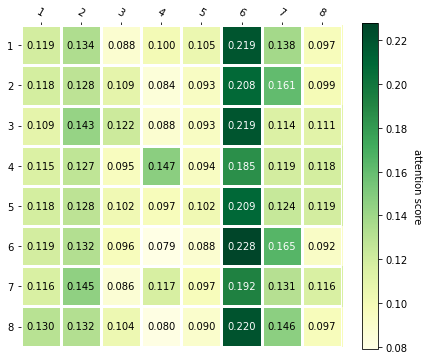

/home/jerry/miniconda3/envs/clip/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error in 3.6
  del sys.path[0]


In [53]:
num_views = 8
view_ids = list(range(1,num_views+1))

fig, ax = plt.subplots(figsize=(7.2,6))

# 好像是网络没训练的原因，看不出来有什么规律，另外还得可视化一下 20 views
im, cbar = heatmap(attentions, view_ids, view_ids, ax=ax,
                   cmap="YlGn", cbarlabel="attention score")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.show()
# 看不出来 padding 这个参数的区别
fig.savefig('images/8airplanes_attn_map.pdf', dpi=400.0, bbox_inches='tight', padding=1.0)

### different formats of 3d object

In [54]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def img_reshape(img):
    img = Image.open(img).convert('RGB')
    # img = img.resize((100,100))
    img = np.asarray(img)
    return img

mv_images_dir = 'multi-modal'
img_arr = []

for img in os.listdir(mv_images_dir):
    img_arr.append(img_reshape(os.path.join(mv_images_dir, img)))


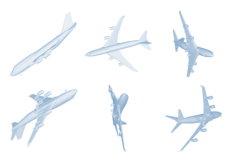

In [56]:
def image_grid(array, ncols=10):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, channels))
    
    return img_grid

result = image_grid(np.array(img_arr), ncols=3)
fig = plt.figure(figsize=(4., 6.))    # width, height

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(result)

### TVCG 表格转图片效果尝试
1. tab 6, 体现 encoder 性能增益
2. tab 7, 体现不带 pos emb. 和 class token 优势
3. tab 8, 消融 attention blocks 数量
4. tab 9, 消融初始化器
5. tab 10, 消融 transition 模块
6. tab 11, 消融 decoder
7. tab 12, 消融 patch-level correlation
8. tab 13, 消融 number of views

In [57]:
# --- 1. data
# AlexNet
#   w/o encoder 42.3 80.6 85.1
#   w/ encoder 47.1↑ 4.8 98.9↑ 18.3 98.8↑ 13.7
# ResNet18
#   w/o encoder 11.2 88.7 91.8
#   w/ encoder 16.0↑ 4.8 96.7↑ 8.0 97.6↑ 5.8
# --- 2. 形式，这几幅要画成什么形式呢？先去看看已有模板吧
# 

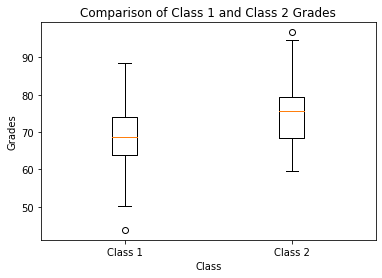

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 生成随机的成绩数据
np.random.seed(42)
class1_grades = np.random.normal(70, 10, 100)
class2_grades = np.random.normal(75, 8, 100)

# 将数据组合成一个列表
data = [class1_grades, class2_grades]

# 绘制箱线图
plt.boxplot(data, labels=['Class 1', 'Class 2'])
plt.title('Comparison of Class 1 and Class 2 Grades')
plt.xlabel('Class')
plt.ylabel('Grades')
plt.show()


### Visualize Wrong Predictions on ShapeNetCore 55
1. The predictions are generated by `analyze_bad_cases.py`
2. Running commands
    ```python
    python analyze_bad_cases.py --dataset SH17 --test_batch_size 20 --task RET --proj_name vf_naive_ret --exp_name SH17-V20-L4H8D512-MR2-Alex-3
    ```
3. The wrong predictions for corresponding views and labels are saved in `wrong_preds.pth`

In [59]:
import torch
import json

In [60]:
wrong_items = torch.load('wrong_preds.pth')
print('len(wrong_items):', len(wrong_items))

len(wrong_items): 21


In [61]:
with open('shrec17_rowid2clsid.json') as f_clsid, open('shrec17_clsid2clsname.json') as f_clsname:
    rowid2clsid = json.load(f_clsid)
    clsid2clsname = json.load(f_clsname)

for i in range(len(wrong_items)):
    label = wrong_items[i]['label']
    label_name = clsid2clsname[rowid2clsid[str(label.item())]]
    pred = wrong_items[i]['pred']
    pred_name = clsid2clsname[rowid2clsid[str(pred.item())]]

    print(f'index: {i}', f"label: {label} ({label_name})", f"pred: {pred} ({pred_name})")

index: 0 label: 22 (monitor) pred: 49 (table)
index: 1 label: 47 (sofa) pred: 41 (pot)
index: 2 label: 22 (monitor) pred: 49 (table)
index: 3 label: 30 (lamp) pred: 44 (rifle)
index: 4 label: 18 (chair) pred: 47 (sofa)
index: 5 label: 24 (faucet) pred: 30 (lamp)
index: 6 label: 22 (monitor) pred: 30 (lamp)
index: 7 label: 8 (bookshelf) pred: 30 (lamp)
index: 8 label: 44 (rifle) pred: 53 (vessel)
index: 9 label: 50 (telephone) pred: 53 (vessel)
index: 10 label: 44 (rifle) pred: 53 (vessel)
index: 11 label: 37 (mug) pred: 30 (lamp)
index: 12 label: 1 (can) pred: 49 (table)
index: 13 label: 12 (cabinet) pred: 49 (table)
index: 14 label: 22 (monitor) pred: 49 (table)
index: 15 label: 4 (bathtub) pred: 49 (table)
index: 16 label: 12 (cabinet) pred: 49 (table)
index: 17 label: 24 (faucet) pred: 30 (lamp)
index: 18 label: 47 (sofa) pred: 49 (table)
index: 19 label: 9 (bottle) pred: 30 (lamp)
index: 20 label: 6 (bench) pred: 53 (vessel)


#### 怎么可视化？
1. PIL
2. matplotlib

In [62]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [63]:
def visualize_images(images, num_rows=2, num_cols=10):
    assert images.shape[0] == num_rows * num_cols, "Number of images does not match the layout"

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Assuming the images are in (N, C, H, W) format
        ax.axis('off')
    plt.show()

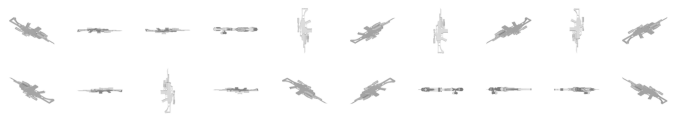

In [64]:
images = wrong_items[10]['views'].numpy()
visualize_images(images)

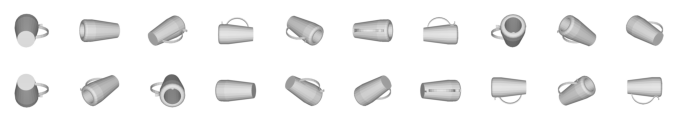

In [65]:
images = wrong_items[11]['views'].numpy()
visualize_images(images)

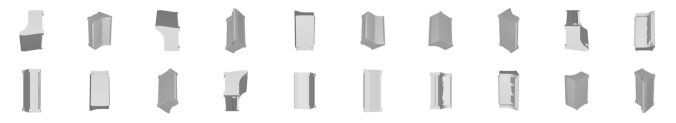

In [66]:
# label: sofa   pred: table
images = wrong_items[18]['views'].numpy()
visualize_images(images)

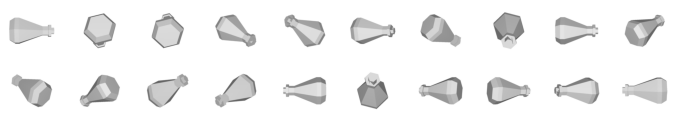

In [67]:
images = wrong_items[19]['views'].numpy()
visualize_images(images)

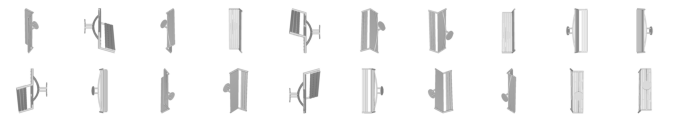

In [68]:
images = wrong_items[20]['views'].numpy()
visualize_images(images)

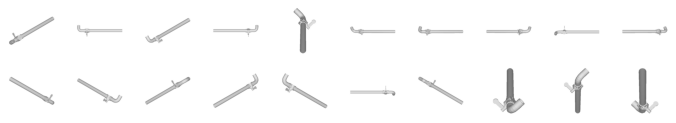

In [8]:
images = wrong_items[17]['views'].numpy()
visualize_images(images)

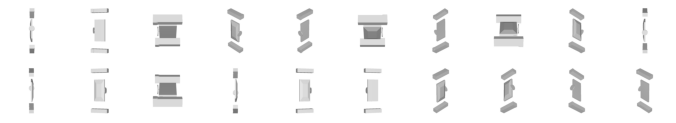

In [9]:
images = wrong_items[0]['views'].numpy()
visualize_images(images)

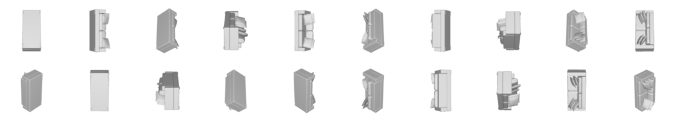

In [69]:
# label: soft, pred: pot
images = wrong_items[1]['views'].numpy()
visualize_images(images)

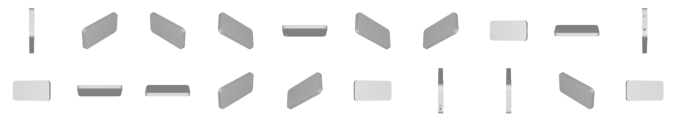

In [10]:
# label: telephone  pred: vessel
images = wrong_items[9]['views'].numpy()
visualize_images(images)

<class 'PIL.PngImagePlugin.PngImageFile'>


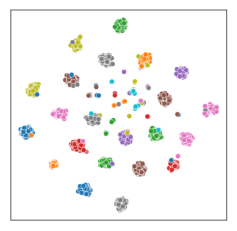

In [26]:
test_img = Image.open('mn40_feats.png') # 读取的图像默认为 RGB 格式
test_img.save('mn40_feats_test.png')
print(type(test_img))

test_img = np.asarray(test_img)
plt.axis('off')
plt.imshow(test_img)    # 能够正常显示

### 可视化 SHREC17 Corresponding Prediction Views
1. 把预测错误的views对应的 prediction views 可视化

In [1]:
import json
import torch

/home/jerry/miniconda3/envs/clip/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wrong_items = torch.load('shrec17_wrong_preds.pth')
print('len(wrong_items):', len(wrong_items))

corresponding_preds = torch.load('shrec17_corresponding_preds.pth')
print('len(corresponding_preds):', len(corresponding_preds))

len(wrong_items): 21
len(corresponding_preds): 21


In [3]:
with open('shrec17_rowid2clsid.json') as f_clsid, open('shrec17_clsid2clsname.json') as f_clsname:
    rowid2clsid = json.load(f_clsid)
    clsid2clsname = json.load(f_clsname)

for i in range(len(corresponding_preds)):
    label = corresponding_preds[i]['label']
    cor_pred = corresponding_preds[i]['cor_pred']
    cls_name = clsid2clsname[rowid2clsid[str(label.item())]]

    print(f'index: {i}', f"cor_pred: {cor_pred} ({cls_name})", f"label: {label} ({cls_name})")

index: 0 cor_pred: 49 (table) label: 49 (table)
index: 1 cor_pred: 41 (pot) label: 41 (pot)
index: 2 cor_pred: 49 (table) label: 49 (table)
index: 3 cor_pred: 44 (rifle) label: 44 (rifle)
index: 4 cor_pred: 47 (sofa) label: 47 (sofa)
index: 5 cor_pred: 30 (lamp) label: 30 (lamp)
index: 6 cor_pred: 30 (lamp) label: 30 (lamp)
index: 7 cor_pred: 30 (lamp) label: 30 (lamp)
index: 8 cor_pred: 53 (vessel) label: 53 (vessel)
index: 9 cor_pred: 53 (vessel) label: 53 (vessel)
index: 10 cor_pred: 53 (vessel) label: 53 (vessel)
index: 11 cor_pred: 30 (lamp) label: 30 (lamp)
index: 12 cor_pred: 49 (table) label: 49 (table)
index: 13 cor_pred: 49 (table) label: 49 (table)
index: 14 cor_pred: 49 (table) label: 49 (table)
index: 15 cor_pred: 49 (table) label: 49 (table)
index: 16 cor_pred: 49 (table) label: 49 (table)
index: 17 cor_pred: 30 (lamp) label: 30 (lamp)
index: 18 cor_pred: 49 (table) label: 49 (table)
index: 19 cor_pred: 30 (lamp) label: 30 (lamp)
index: 20 cor_pred: 53 (vessel) label: 53 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def visualize_images(images, num_rows=2, num_cols=10):
    assert images.shape[0] == num_rows * num_cols, "Number of images does not match the layout"

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Assuming the images are in (N, C, H, W) format
        ax.axis('off')
    plt.show()

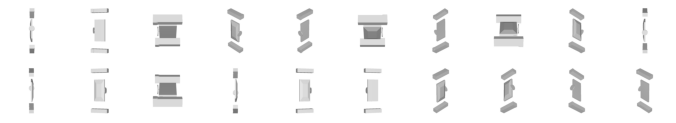

In [6]:
# label: monitor
images = wrong_items[0]['views'].numpy()
visualize_images(images)

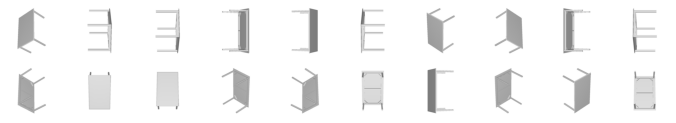

In [7]:
# pred: table
images = corresponding_preds[0]['views'].numpy()
visualize_images(images)

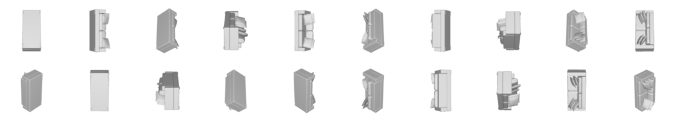

In [8]:
# label: sofa
images = wrong_items[1]['views'].numpy()
visualize_images(images)

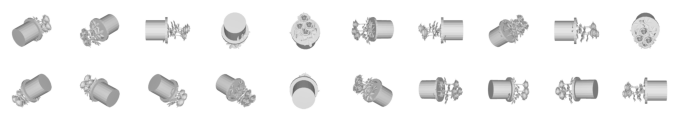

In [9]:
# pred: pot
images = corresponding_preds[1]['views'].numpy()
visualize_images(images)

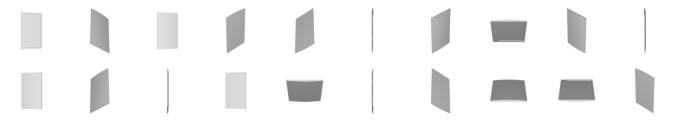

In [10]:
# label: monitor
images = wrong_items[2]['views'].numpy()
visualize_images(images)

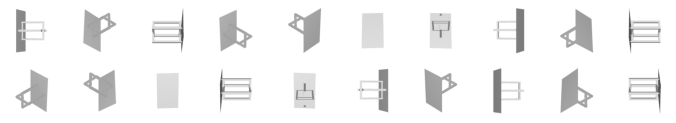

In [11]:
# pred: table
images = corresponding_preds[2]['views'].numpy()
visualize_images(images)

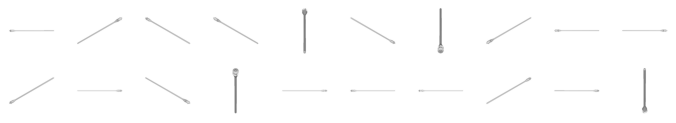

In [12]:
# label: lamp
images = wrong_items[3]['views'].numpy()
visualize_images(images)

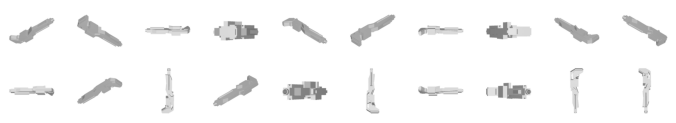

In [14]:
# pred: rifle
images = corresponding_preds[3]['views'].numpy()
visualize_images(images)

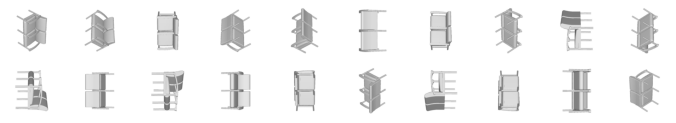

In [15]:
# label: chair
images = wrong_items[4]['views'].numpy()
visualize_images(images)

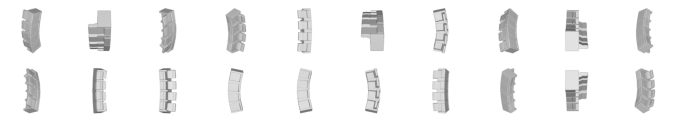

In [16]:
# pred: sofa
images = corresponding_preds[4]['views'].numpy()
visualize_images(images)

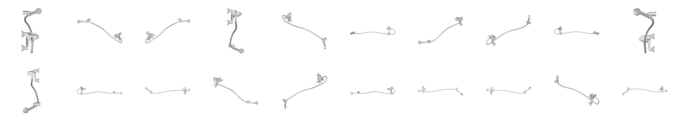

In [17]:
# label: faucet
images = wrong_items[5]['views'].numpy()
visualize_images(images)

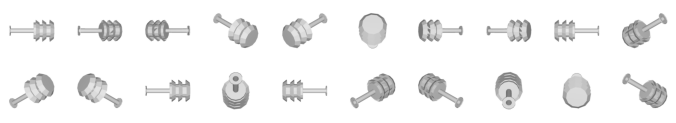

In [18]:
# pred: lamp
images = corresponding_preds[5]['views'].numpy()
visualize_images(images)

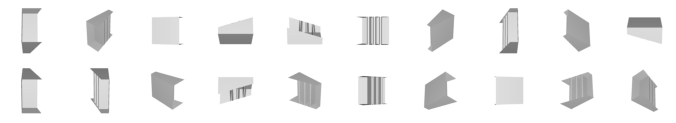

In [19]:
# label: bookshelf
images = wrong_items[7]['views'].numpy()
visualize_images(images)

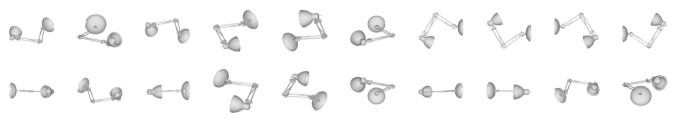

In [21]:
# pred: lamp
images = corresponding_preds[7]['views'].numpy()
visualize_images(images)

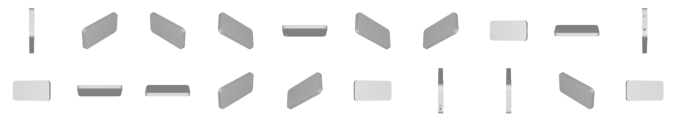

In [22]:
# label: telephone
images = wrong_items[9]['views'].numpy()
visualize_images(images)

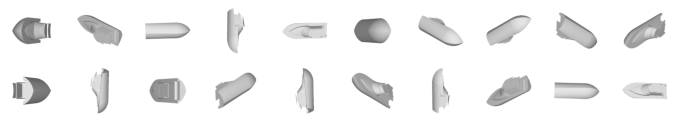

In [23]:
# pred: vessel
images = corresponding_preds[9]['views'].numpy()
visualize_images(images)

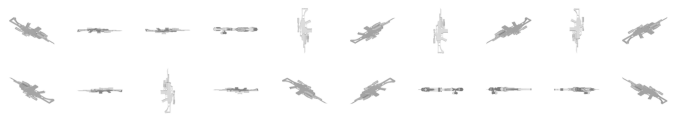

In [6]:
# label: rifle
images = wrong_items[10]['views'].numpy()
visualize_images(images)

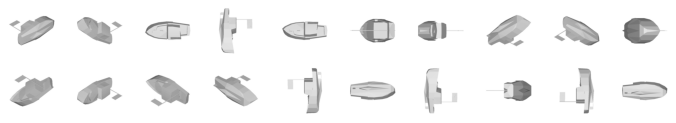

In [7]:
# pred: vessel
images = corresponding_preds[10]['views'].numpy()
visualize_images(images)

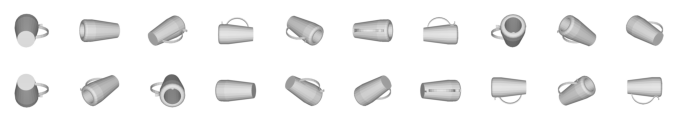

In [24]:
# label: mug
images = wrong_items[11]['views'].numpy()
visualize_images(images)

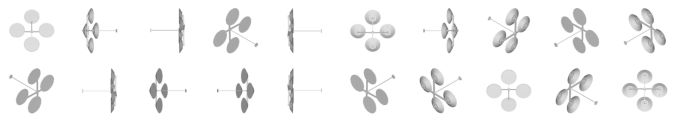

In [25]:
# pred: lamp
images = corresponding_preds[11]['views'].numpy()
visualize_images(images)

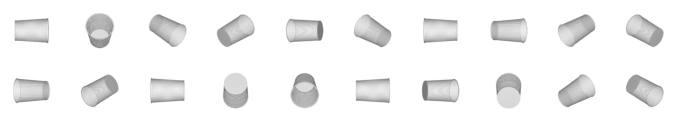

In [26]:
# label: can
images = wrong_items[12]['views'].numpy()
visualize_images(images)

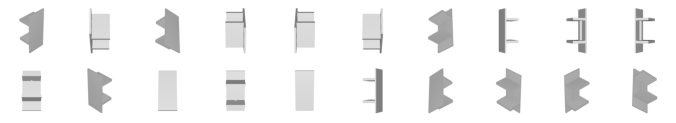

In [27]:
# label: table
images = corresponding_preds[12]['views'].numpy()
visualize_images(images)

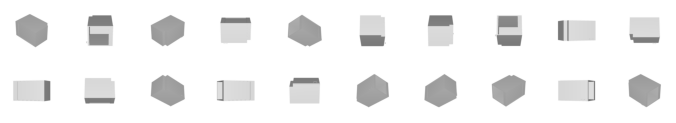

In [28]:
# label: cabinet
images = wrong_items[13]['views'].numpy()
visualize_images(images)

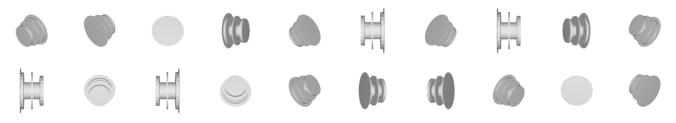

In [29]:
# label: table
images = corresponding_preds[13]['views'].numpy()
visualize_images(images)

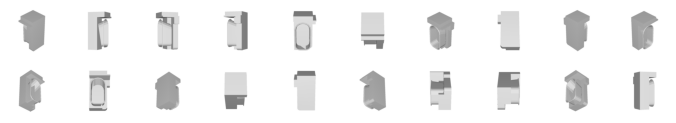

In [30]:
# label: bathtub
images = wrong_items[15]['views'].numpy()
visualize_images(images)

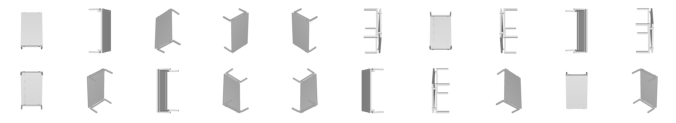

In [31]:
# label: table
images = corresponding_preds[15]['views'].numpy()
visualize_images(images)

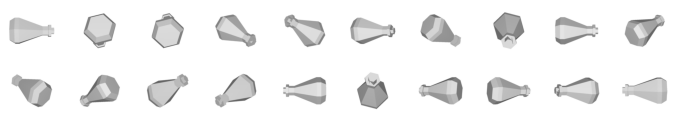

In [32]:
# label: bottle
images = wrong_items[19]['views'].numpy()
visualize_images(images)

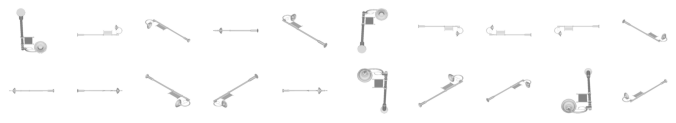

In [33]:
# label: lamp
images = corresponding_preds[19]['views'].numpy()
visualize_images(images)

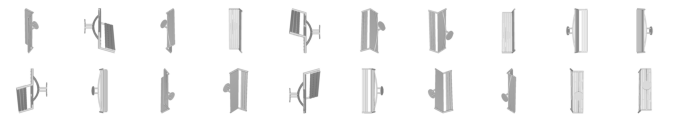

In [34]:
# label: bench
images = wrong_items[20]['views'].numpy()
visualize_images(images)

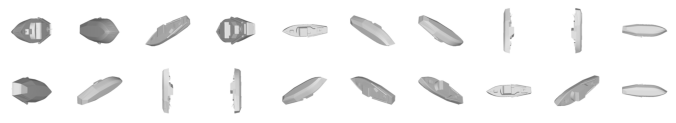

In [35]:
# label: vessel
images = corresponding_preds[20]['views'].numpy()
visualize_images(images)

### 可视化 ModelNet40 Corresponding Prediction Views
1. 把预测错误的views对应的 prediction views 可视化

In [1]:
import torch
import json

/home/jerry/miniconda3/envs/clip/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mn40_wrong_items = torch.load('mn40_wrong_preds.pth')
print('len(mn40_wrong_items):', len(mn40_wrong_items))

mn40_corresponding_preds = torch.load('mn40_corresponding_preds.pth')
print('len(mn40_corresponding_preds):', len(mn40_corresponding_preds))

len(mn40_wrong_items): 40
len(mn40_corresponding_preds): 40


In [15]:
with open('mn40_rowid2clsid.json') as f_clsid:
    rowid2clsid = json.load(f_clsid)

for i in range(len(mn40_wrong_items)):
    label = mn40_wrong_items[i]['label']
    label_name = rowid2clsid[str(label.item())]
    pred = mn40_wrong_items[i]['pred']
    pred_name = rowid2clsid[str(pred.item())]

    print(f'index: {i}', f"label: {label} ({label_name})", f"pred: {pred} ({pred_name})")

index: 0 label: 1 (bathtub) pred: 2 (bed)
index: 1 label: 1 (bathtub) pred: 6 (bowl)
index: 2 label: 1 (bathtub) pred: 35 (toilet)
index: 3 label: 1 (bathtub) pred: 2 (bed)
index: 4 label: 1 (bathtub) pred: 6 (bowl)
index: 5 label: 1 (bathtub) pred: 8 (chair)
index: 6 label: 1 (bathtub) pred: 16 (glass_box)
index: 7 label: 1 (bathtub) pred: 3 (bench)
index: 8 label: 1 (bathtub) pred: 8 (chair)
index: 9 label: 2 (bed) pred: 3 (bench)
index: 10 label: 3 (bench) pred: 12 (desk)
index: 11 label: 3 (bench) pred: 11 (curtain)
index: 12 label: 4 (bookshelf) pred: 8 (chair)
index: 13 label: 4 (bookshelf) pred: 31 (stairs)
index: 14 label: 4 (bookshelf) pred: 11 (curtain)
index: 15 label: 4 (bookshelf) pred: 13 (door)
index: 16 label: 4 (bookshelf) pred: 38 (wardrobe)
index: 17 label: 4 (bookshelf) pred: 8 (chair)
index: 18 label: 5 (bottle) pred: 11 (curtain)
index: 19 label: 5 (bottle) pred: 6 (bowl)
index: 20 label: 5 (bottle) pred: 3 (bench)
index: 21 label: 5 (bottle) pred: 8 (chair)
index

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_images(images, num_rows=2, num_cols=10):
    assert images.shape[0] == num_rows * num_cols, "Number of images does not match the layout"

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Assuming the images are in (N, C, H, W) format
        ax.axis('off')
    plt.show()

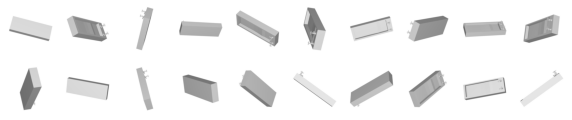

In [17]:
# label: bathtub    这和 bed 非常像啊
images = mn40_wrong_items[0]['views'].numpy()
visualize_images(images)

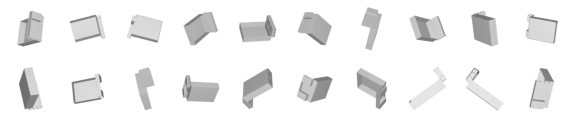

In [18]:
# label: bed
images = mn40_corresponding_preds[0]['views'].numpy()
visualize_images(images)

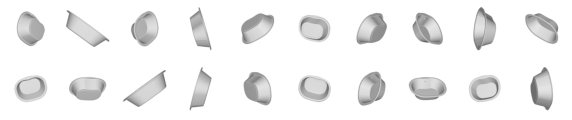

In [19]:
# label: bathtub    这和 bowl 也很像啊
images = mn40_wrong_items[1]['views'].numpy()
visualize_images(images)

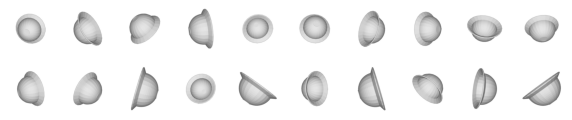

In [20]:
# label: bowl
images = mn40_corresponding_preds[1]['views'].numpy()
visualize_images(images)

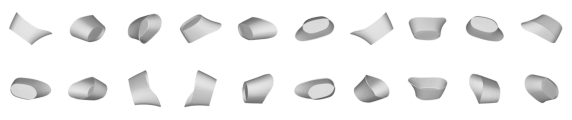

In [21]:
# label: bathtub
images = mn40_wrong_items[2]['views'].numpy()
visualize_images(images)

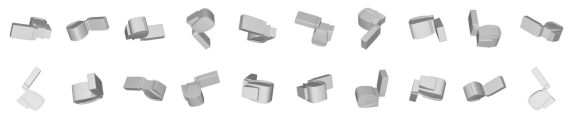

In [22]:
# label: toilet
images = mn40_corresponding_preds[2]['views'].numpy()
visualize_images(images)

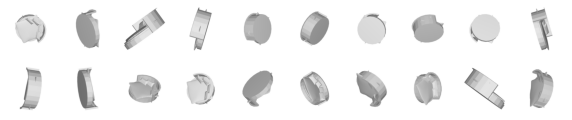

In [23]:
# label: bed
images = mn40_wrong_items[9]['views'].numpy()
visualize_images(images)

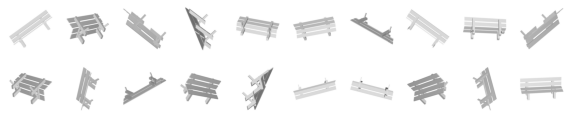

In [24]:
# label: bench
images = mn40_corresponding_preds[9]['views'].numpy()
visualize_images(images)

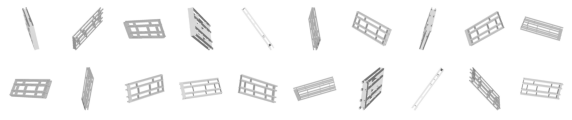

In [25]:
# label: bookshelf
images = mn40_wrong_items[12]['views'].numpy()
visualize_images(images)

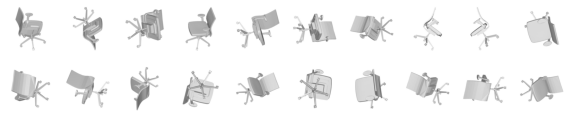

In [26]:
# label: chair
images = mn40_corresponding_preds[12]['views'].numpy()
visualize_images(images)

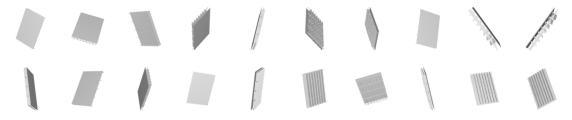

In [27]:
# label: bookshelf
images = mn40_wrong_items[13]['views'].numpy()
visualize_images(images)

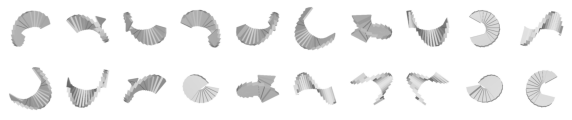

In [28]:
# label: stairs
images = mn40_corresponding_preds[13]['views'].numpy()
visualize_images(images)

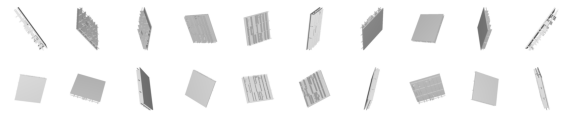

In [29]:
# label: bookshelf  这和窗帘太像了，简直分不出来
images = mn40_wrong_items[14]['views'].numpy()
visualize_images(images)

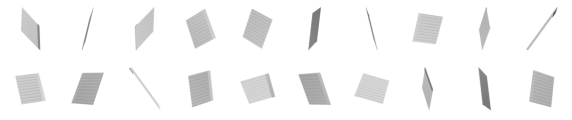

In [30]:
# pred: curtain
images = mn40_corresponding_preds[14]['views'].numpy()
visualize_images(images)

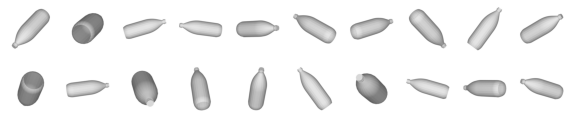

In [31]:
# label: bottle
images = mn40_wrong_items[19]['views'].numpy()
visualize_images(images)

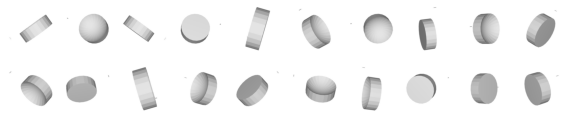

In [32]:
# label: bowl
images = mn40_corresponding_preds[19]['views'].numpy()
visualize_images(images)

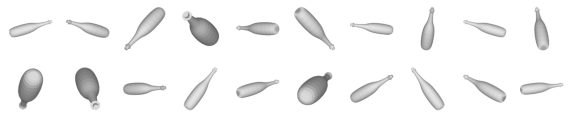

In [33]:
# label: bottle
images = mn40_wrong_items[23]['views'].numpy()
visualize_images(images)

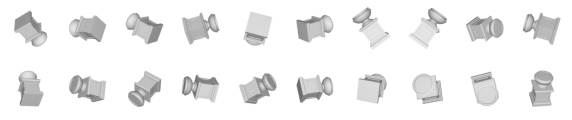

In [34]:
# label: flower pot 这个 flower pot 和 rowid=28、29的 bottle 很像了
images = mn40_corresponding_preds[23]['views'].numpy()
visualize_images(images)

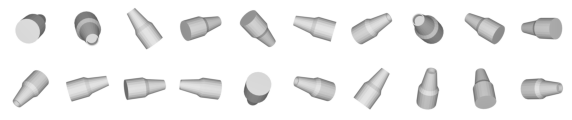

In [35]:
# label: bottle
images = mn40_wrong_items[28]['views'].numpy()
visualize_images(images)

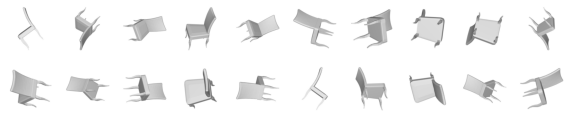

In [36]:
# label: chair
images = mn40_corresponding_preds[28]['views'].numpy()
visualize_images(images)

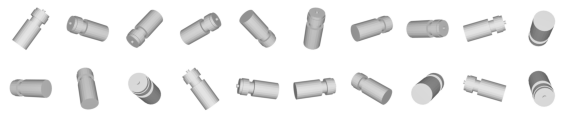

In [37]:
# label: bottle
images = mn40_wrong_items[29]['views'].numpy()
visualize_images(images)

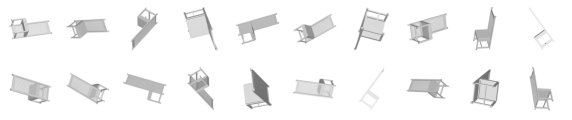

In [38]:
# label: chair
images = mn40_corresponding_preds[29]['views'].numpy()
visualize_images(images)

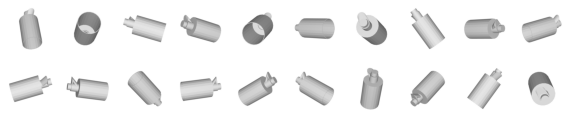

In [9]:
# label: bottle
images = mn40_wrong_items[36]['views'].numpy()
visualize_images(images)

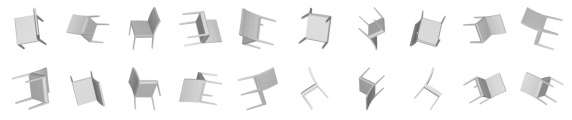

In [10]:
# pred: car
images = mn40_corresponding_preds[36]['views'].numpy()
visualize_images(images)

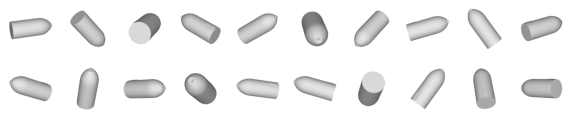

In [11]:
# label: bottle
images = mn40_wrong_items[37]['views'].numpy()
visualize_images(images)

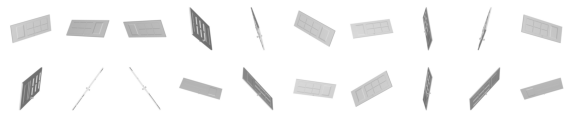

In [12]:
# pred: door
images = mn40_corresponding_preds[37]['views'].numpy()
visualize_images(images)

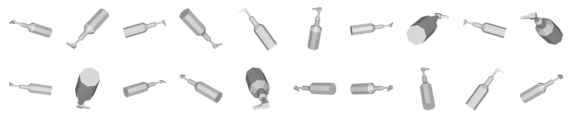

In [13]:
# label: bottle
images = mn40_wrong_items[38]['views'].numpy()
visualize_images(images)

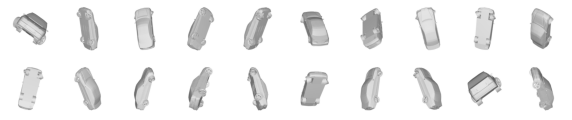

In [14]:
# pred: car
images = mn40_corresponding_preds[38]['views'].numpy()
visualize_images(images)

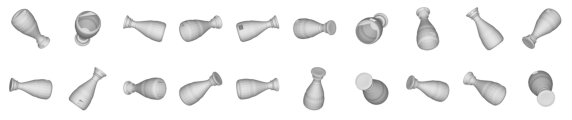

In [15]:
# label: bottle
images = mn40_wrong_items[39]['views'].numpy()
visualize_images(images)

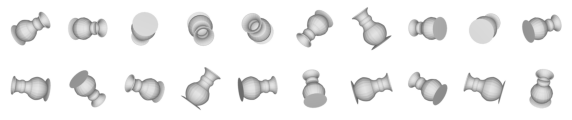

In [16]:
# pred: flower pot
images = mn40_corresponding_preds[39]['views'].numpy()
visualize_images(images)

### 改进图片排版
1. 首先别放这么多视图，四五个视图足矣
2. 识别和预测分别放多个视图？还是识别放多个，预测也放多个
    1. 分别放多个吧，多视图识别嘛

#### bad cases for mn40

In [1]:
import torch
import json

/home/jerry/miniconda3/envs/clip/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mn40_wrong_items = torch.load('mn40_wrong_preds.pth')
print('len(mn40_wrong_items):', len(mn40_wrong_items))

mn40_corresponding_preds = torch.load('mn40_corresponding_preds.pth')
print('len(mn40_corresponding_preds):', len(mn40_corresponding_preds))

len(mn40_wrong_items): 40
len(mn40_corresponding_preds): 40


In [3]:
with open('mn40_rowid2clsid.json') as f_clsid:
    rowid2clsid = json.load(f_clsid)

for i in range(len(mn40_wrong_items)):
    label = mn40_wrong_items[i]['label']
    label_name = rowid2clsid[str(label.item())]
    pred = mn40_wrong_items[i]['pred']
    pred_name = rowid2clsid[str(pred.item())]

    print(f'index: {i}', f"label: {label} ({label_name})", f"pred: {pred} ({pred_name})")

index: 0 label: 1 (bathtub) pred: 2 (bed)
index: 1 label: 1 (bathtub) pred: 6 (bowl)
index: 2 label: 1 (bathtub) pred: 35 (toilet)
index: 3 label: 1 (bathtub) pred: 2 (bed)
index: 4 label: 1 (bathtub) pred: 6 (bowl)
index: 5 label: 1 (bathtub) pred: 8 (chair)
index: 6 label: 1 (bathtub) pred: 16 (glass_box)
index: 7 label: 1 (bathtub) pred: 3 (bench)
index: 8 label: 1 (bathtub) pred: 8 (chair)
index: 9 label: 2 (bed) pred: 3 (bench)
index: 10 label: 3 (bench) pred: 12 (desk)
index: 11 label: 3 (bench) pred: 11 (curtain)
index: 12 label: 4 (bookshelf) pred: 8 (chair)
index: 13 label: 4 (bookshelf) pred: 31 (stairs)
index: 14 label: 4 (bookshelf) pred: 11 (curtain)
index: 15 label: 4 (bookshelf) pred: 13 (door)
index: 16 label: 4 (bookshelf) pred: 38 (wardrobe)
index: 17 label: 4 (bookshelf) pred: 8 (chair)
index: 18 label: 5 (bottle) pred: 11 (curtain)
index: 19 label: 5 (bottle) pred: 6 (bowl)
index: 20 label: 5 (bottle) pred: 3 (bench)
index: 21 label: 5 (bottle) pred: 8 (chair)
index

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_images(img_name, images, num_rows=1, num_cols=5, ):
    assert images.shape[0] == num_rows * num_cols, "Number of images does not match the layout"

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Assuming the images are in (N, C, H, W) format
        ax.axis('off')
    fig.savefig(img_name, bbox_inches='tight', dpi=400.0)
    plt.show()

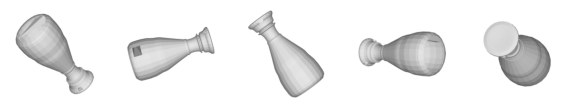

In [8]:
# 挑选5个视图

# label: bottle
images = mn40_wrong_items[39]['views'][::4].numpy()
visualize_images('mn40_bad_cases/39_gt_bottle.pdf', images)

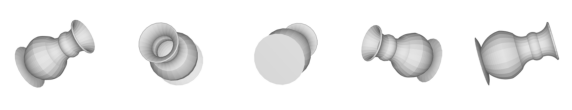

In [9]:
# pred: flower pot
images = mn40_corresponding_preds[39]['views'][::4].numpy()
visualize_images('mn40_bad_cases/39_pred_flowerpot.pdf', images)

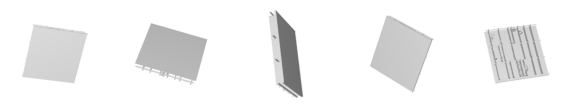

In [19]:
# label: bookshelf
images = mn40_wrong_items[14]['views'][10:15].numpy()
visualize_images('mn40_bad_cases/14_gt_bookshelf.pdf', images)

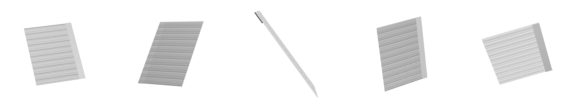

In [18]:
# pred: curtain
images = mn40_corresponding_preds[14]['views'][10:15].numpy()
visualize_images('mn40_bad_cases/14_pred_curtain.pdf', images)

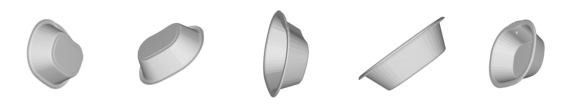

In [20]:
# label: bathtub    这和 bowl 也很像啊
images = mn40_wrong_items[1]['views'][::4].numpy()
visualize_images('mn40_bad_cases/1_gt_bathtub.pdf', images)

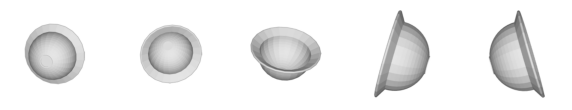

In [21]:
# label: bowl
images = mn40_corresponding_preds[1]['views'][::4].numpy()
visualize_images('mn40_bad_cases/1_pred_bowl.pdf', images)

#### bad cases for shrec17

In [22]:
shrec17_wrong_items = torch.load('shrec17_wrong_preds.pth')
print('len(shrec17_wrong_items):', len(shrec17_wrong_items))

shrec17_corresponding_preds = torch.load('shrec17_corresponding_preds.pth')
print('len(shrec17_corresponding_preds):', len(shrec17_corresponding_preds))

len(shrec17_wrong_items): 21
len(shrec17_corresponding_preds): 21


In [24]:
with open('shrec17_rowid2clsid.json') as f_clsid, open('shrec17_clsid2clsname.json') as f_clsname:
    rowid2clsid = json.load(f_clsid)
    clsid2clsname = json.load(f_clsname)

for i in range(len(shrec17_corresponding_preds)):
    label = shrec17_corresponding_preds[i]['label']
    cor_pred = shrec17_corresponding_preds[i]['cor_pred']
    cls_name = clsid2clsname[rowid2clsid[str(label.item())]]

    print(f'index: {i}', f"cor_pred: {cor_pred} ({cls_name})", f"label: {label} ({cls_name})")

index: 0 cor_pred: 49 (table) label: 49 (table)
index: 1 cor_pred: 41 (pot) label: 41 (pot)
index: 2 cor_pred: 49 (table) label: 49 (table)
index: 3 cor_pred: 44 (rifle) label: 44 (rifle)
index: 4 cor_pred: 47 (sofa) label: 47 (sofa)
index: 5 cor_pred: 30 (lamp) label: 30 (lamp)
index: 6 cor_pred: 30 (lamp) label: 30 (lamp)
index: 7 cor_pred: 30 (lamp) label: 30 (lamp)
index: 8 cor_pred: 53 (vessel) label: 53 (vessel)
index: 9 cor_pred: 53 (vessel) label: 53 (vessel)
index: 10 cor_pred: 53 (vessel) label: 53 (vessel)
index: 11 cor_pred: 30 (lamp) label: 30 (lamp)
index: 12 cor_pred: 49 (table) label: 49 (table)
index: 13 cor_pred: 49 (table) label: 49 (table)
index: 14 cor_pred: 49 (table) label: 49 (table)
index: 15 cor_pred: 49 (table) label: 49 (table)
index: 16 cor_pred: 49 (table) label: 49 (table)
index: 17 cor_pred: 30 (lamp) label: 30 (lamp)
index: 18 cor_pred: 49 (table) label: 49 (table)
index: 19 cor_pred: 30 (lamp) label: 30 (lamp)
index: 20 cor_pred: 53 (vessel) label: 53 

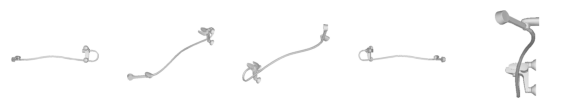

In [34]:
# label: faucet
images = shrec17_wrong_items[5]['views'][5:10].numpy()
visualize_images('shrec17_bad_cases/5_gt_faucet.pdf', images)

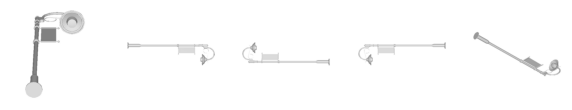

In [33]:
# pred: lamp
images = shrec17_corresponding_preds[19]['views'][5:10].numpy()
visualize_images('shrec17_bad_cases/19_pred_lamp.pdf', images)

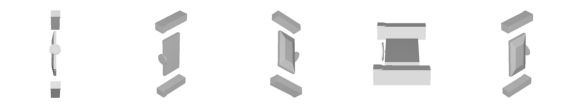

In [35]:
# label: monitor
images = shrec17_wrong_items[0]['views'][::4].numpy()
visualize_images('shrec17_bad_cases/0_gt_monitor.pdf', images)

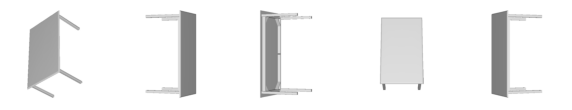

In [36]:
# pred: table
images = shrec17_corresponding_preds[0]['views'][::4].numpy()
visualize_images('shrec17_bad_cases/0_pred_table.pdf', images)

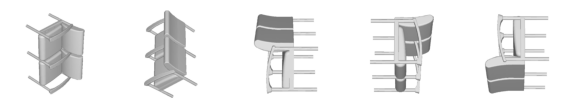

In [37]:
# label: chair
images = shrec17_wrong_items[4]['views'][::4].numpy()
visualize_images('shrec17_bad_cases/4_gt_chair.pdf', images)

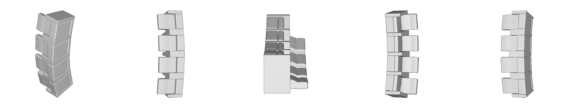

In [38]:
# pred: sofa
images = shrec17_corresponding_preds[4]['views'][::4].numpy()
visualize_images('shrec17_bad_cases/4_pred_sofa.pdf', images)

### convert png to pdf

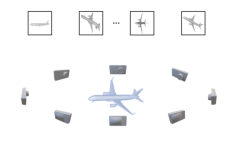

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5))  # Control figure size
img = plt.imread('images/independent_views.png')

ax.imshow(img)
ax.axis('off')

plt.savefig('images/independent_views.pdf', dpi=400.0, bbox_inches='tight')
plt.show()

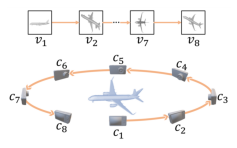

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5))  # Control figure size
img = plt.imread('images/view_sequence.png')

ax.imshow(img)
ax.axis('off')

plt.savefig('images/view_sequence.pdf', dpi=400.0, bbox_inches='tight')
plt.show()

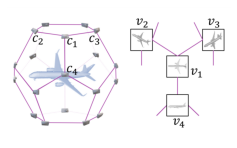

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5))  # Control figure size
img = plt.imread('images/view_graph.png')

ax.imshow(img)
ax.axis('off')

plt.savefig('images/view_graph.pdf', dpi=400.0, bbox_inches='tight')
plt.show()

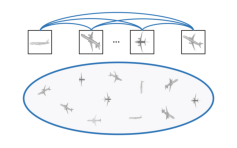

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5))  # Control figure size
img = plt.imread('images/view_set.png')

ax.imshow(img)
ax.axis('off')

plt.savefig('images/view_set.pdf', dpi=400.0, bbox_inches='tight')
plt.show()

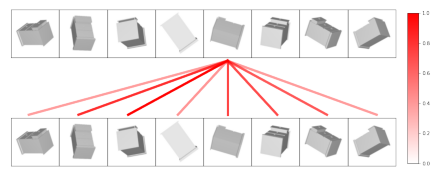

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7.83, 3))  # Control figure size
img = plt.imread('images/8nightstands_attn_lines.png')

ax.imshow(img)
ax.axis('off')

plt.savefig('images/8nightstands_attn_lines.pdf', dpi=400.0, bbox_inches='tight')
plt.show()

### 